## Project about the Adaboost Machine Learning Algorithm. 


### So why was Adaboost discovered?

The reason to why it was discovered was to deal with the issue of bias of weak classifiers. A weak classifier can be defined as one that cannot bring down the training error to zero. So, to solve this problem it was suggested that several weak classifiers can be used together as an ensemble to form a much more powerful single classifier which will significantly reduce the bias. This single classifier is Adaboost which in full called Adaptive boosting.  In my example for the weak classifier I am going to use a decision stump. The data problems that Adaboost solves are in the area of binary classification.

In [1]:
# import libraries
%matplotlib inline
import numpy as np
import matplotlib as cm
import matplotlib.pyplot as plt
import os

In [2]:
def mixGauss(means, sigmas, n):

    means = np.array(means)
    sigmas = np.array(sigmas)

    d = means.shape[1]
    num_classes = sigmas.size
    data = np.full((n * num_classes, d), np.inf)
    labels = np.zeros(n * num_classes)

    for idx, sigma in enumerate(sigmas):
        data[idx * n:(idx + 1) * n] = np.random.multivariate_normal(mean=means[idx], cov=np.eye(d) * sigmas[idx] ** 2,
                                                                    size=n)
        labels[idx * n:(idx + 1) * n] = idx 
        
    if(num_classes == 2):
        labels[labels==0] = -1

    return data, labels

X, Y= mixGauss([[0,0], [1,1]], [0.25, 0.25], 300)
Xte, Yte= mixGauss([[0,0], [1,1]], [0.25, 0.25], 300)
X1d, Y1d= mixGauss([[0,0], [1,1]], [0.25, 0.25], 300)

In [3]:
def flipLabels(Y, perc):

    if perc < 1 or perc > 100:
        print("p should be a percentage value between 0 and 100.")
        return -1

    if any(np.abs(Y) != 1):
        print("The values of Ytr should be +1 or -1.")
        return -1

    Y_noisy = np.copy(np.squeeze(Y))
    if Y_noisy.ndim > 1:
        print("Please supply a label array with only one dimension")
        return -1

    n = Y_noisy.size
    n_flips = int(np.floor(n * perc / 100))
    idx_to_flip = np.random.choice(n, size=n_flips, replace=False)
    Y_noisy[idx_to_flip] = -Y_noisy[idx_to_flip]

    return Y_noisy

### Setting the stage for boosting in general. 
1. Given a set of weak classifiers $ B $, with alot of bias. 
2. To generate a strong classifier without bias $$B=\sum_{i=0}^{N}\  \alpha{b(\vec{x})}$$ we combine all the weak classifiers together while iterating. In each iteration we add a classifier $$ \alpha{b(\vec{x})}$$.
3. At the end of all the iterations we get the weighted sum of the all the classifiers. 
4. The ensemble is constructed using a system similar to gradient descent but in the function space.
5. So we have the loss function $$L(B) = \frac{1}{n}\sum(B(x_i),y_i)$$
6. After we have finished about $k$ iterations then on the $k+1$ iteration we want a classifier that is going to minimise the loss function most. In the form $$ \underset{k+1}{x} = \underset{b\in B}{argmin} L (B_t+\alpha{b_t})$$
7. Above is the general set up of boosting algorithms. For Adaboost specifically check out the next cell. 

### Adaptive Boosting aka AdaBoost.
1. So the set up for adaboost is in the form, $$(y_i \in [-1,1])$$
2. We have a set of weak learners $b \in B$ that are binary such that $$ b(x_i)\in [-1,1]$$ for all $x$.
3. To get the best alpha$ (\alpha) $ we perform a line search, using step size. 
4. For the loss function, the exponetial type is employed. That is in the form $$l(B)=\sum_{i=0}^{n}{\exp(-y_iB(x_i)})$$
5. To get the step size we have $\alpha = $ $\frac{1}{2}log\frac{1-Episilon}{Episilon}$.
6. The final prediction is got with $Yred = sign( \sum_{i} \alpha_i b(xtest))$

### Algorithm Implimentation.

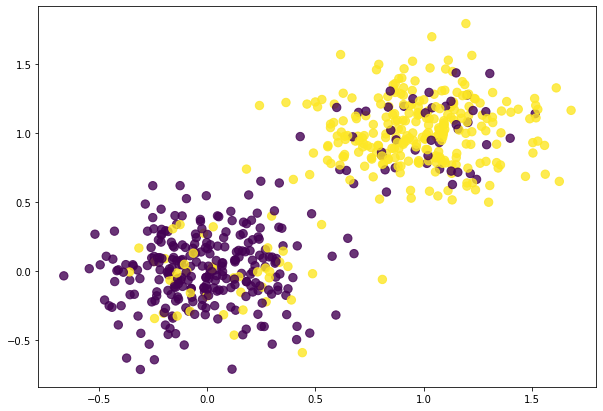

In [4]:
# The data is generated using the functions provided in the course. The first assignment in particular. 
fig = plt.figure(figsize=(10,7)) 
Y2_n0 = flipLabels(Y,15)
plt.scatter(X[:,0], X[:,1], s=70, c=Y2_n0, alpha=0.8)

In [5]:
class AdaptiveBoost():

    def __init__(self, n_classifier):
        self.n_classifier = n_classifier

    def xtrain(self, X, target):
        n, Dim = X.shape

        # First let us initialize the weights with one common value. By convention its 1/number of 
        # observations
        weights= np.full(n, (1 / n))
        
        # Because we are going to be iterating over different classifiers so we need to store them somewhere
        self.classifiers = []
        
        #Now we can loop over the classifiers to compute there different results and then merge them together.
        for i in range(self.n_classifier):
            classifier = WeakClassifier()

            minimum_err= float('inf')
            
            #Lets find the best thresfrom X and dimension
            for dimension in range(Dim):
                X_column = X[:, dimension]  # Get a particular column
                thresholds = np.unique(X_column) #From every column lets get unique values to give them 
                #required polarity based on value

                #Loop through the thresholds to assign polarity
                for thres in thresholds:
                    # Set the polarity to 1. The threshold is going to be based on this value. 
                    p = 1
                    predicted_labels = np.ones(n)
                    predicted_labels[X_column < thres] = -1 #Storage for the predicted labels

                    #Sum up the errors for the labels classified wrongly.
                    wrong_classifications = weights[target != predicted_labels]
                    err= sum(wrong_classifications)
                     
                    #Good error rates must be lower than 0.5, the weak classifier should be able to predict
                    # atleast half the labels. 
                    if err> 0.5:
                        err= 1 - err
                        p = -1

                    #Lets store the best configuration information 
                    if err< minimum_err:
                        classifier.plrty = p
                        classifier.thres= thres
                        classifier.column_idx = dimension
                        minimum_err= err

            # The last step is calculating alpha, first we need to get the Episilon
            Episilon = 3e-20
            
            # Calculate alpha
            classifier.alpha = 0.5 * np.log((1.0 - minimum_err+ Episilon) / (minimum_err+ Episilon))

        
            # Update the weights
            weights*= np.exp(-classifier.alpha * target * predicted_labels) 
        
            weights/= np.sum(weights)
            
            # Add the classifier to the list created, this is the combination step.
            self.classifiers.append(classifier)
            
        #After the training phase then predict, using Xtest for the final label. 
    def predict(self, X):
        classifier_preds = [classifier.alpha * classifier.predict(X) for classifier in self.classifiers]
        Predicted_y = np.sum(classifier_preds, axis=0)
        Predicted_y = np.sign(Predicted_y)

        return Predicted_y

class WeakClassifier():
    def __init__(self):
        self.plrty = 1
        self.column_idx = None
        self.thres= None
        self.alpha = None

    def predict(self, X):
        n = X.shape[0]
        X_column = X[:, self.column_idx]
        predicted_labels = np.ones(n) 
        if self.plrty == 1:  # From the literature the classification is always between -1 and 1 
            predicted_labels[X_column < self.thres] = -1
        else:
            predicted_labels[X_column > self.thres] = -1

        return predicted_labels
    
def accuracy(Ytrue, Predicted_y):
    accuracy = np.sum(Ytrue == Predicted_y) / len(Ytrue)
    return accuracy   

In [6]:
ada = AdaptiveBoost(8)
ada.xtrain(X,Y)
Pred = ada.predict(Xte)
accuracy(Y,Pred)

0.95

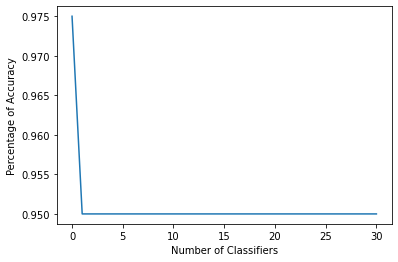

In [66]:
#The effect of many cla
AdaboostVis(X,Y,Xte,Y,31)

Text(0.5, 1.0, 'Predicted Y')

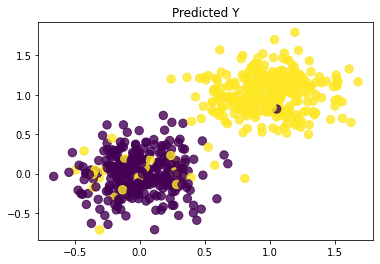

In [7]:
plt.scatter(X[:,0], X[:,1], s=70, c=Pred, alpha=0.8)
plt.title("Predicted Y")

Text(0.5, 1.0, 'True Y')

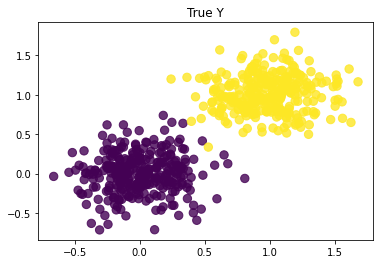

In [8]:
plt.scatter(X[:,0], X[:,1], s=70, c=Y, alpha=0.8)
plt.title('True Y')

In [9]:
## Add some noise
ada2 = AdaptiveBoost(20)
ada2.xtrain(X,Y2_n0)
Pred2 = ada.predict(Xte)
accuracy(Y2_n0,Pred)

0.81

Text(0.5, 1.0, 'Predicted Y with Noise Y2_n0')

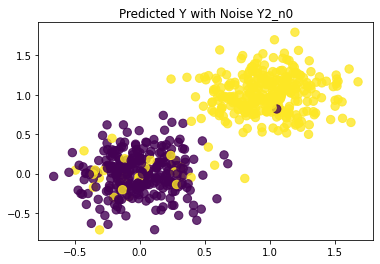

In [10]:
plt.scatter(X[:,0], X[:,1], s=70, c=Pred2, alpha=0.8)
plt.title('Predicted Y with Noise Y2_n0')

Text(0.5, 1.0, 'True Y2_n0 with Noise')

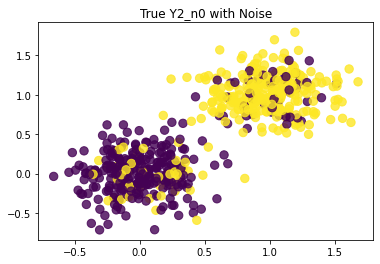

In [11]:
plt.scatter(X[:,0], X[:,1], s=70, c=Y2_n0, alpha=0.8)
plt.title('True Y2_n0 with Noise')

### Solve the same problem with Sklearn Machine learning library using support vector classifier as the base or weak classifier and adaboost as the combiner. 

In [12]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

# We will use a linear kernel for the support vector classifier. It should be noted that you can use any classifier 
#with adaboost. In our example above we use a decision stump which is a tree of just one depth. 
svc=SVC(probability=True, kernel='linear')
sklearnboost =AdaBoostClassifier(n_estimators=10, base_estimator=svc,learning_rate=1)

#Fit the model with the same data as above via training
sklearnmodel = sklearnboost.fit(X, Y)

#Predict the response for test dataset
sklearnPredict= sklearnmodel.predict(Xte)
accuracy(Y,sklearnPredict)

0.9983333333333333

Text(0.5, 1.0, 'Adaboost Sklearn with SVC')

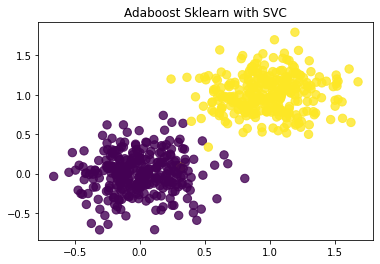

In [13]:
plt.scatter(X[:,0], X[:,1], s=70, c=sklearnPredict, alpha=0.8)
plt.title('Adaboost Sklearn with SVC')

### From the visual above and accuracy score we can easily tell that adaboost has done well in this task.

In [14]:
#Now lets add some noise. 
# We will use a linear kernel for the support vector machine. 
svc2=SVC(probability=True, kernel='linear')
sklearnboost =AdaBoostClassifier(n_estimators=14, base_estimator=svc2,learning_rate=1)

#Fit the model with the same data as above via training
sklearnmodel2 = sklearnboost.fit(X, Y2_n0)

#Predict the response for test dataset
sklearnPredict2= sklearnmodel2.predict(Xte)
accuracy(Y,sklearnPredict2)

0.8066666666666666

Text(0.5, 1.0, 'Adaboost Sklearn with SVC')

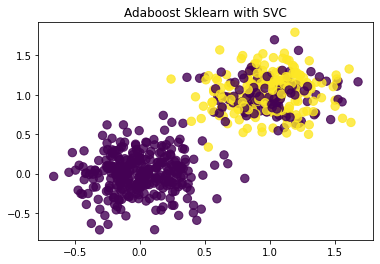

In [15]:
plt.scatter(X[:,0], X[:,1], s=70, c=sklearnPredict2, alpha=0.8)
plt.title('Adaboost Sklearn with SVC')

### Training the algorithms on real breast cancer datasets from sklearn. 

In [16]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [17]:
dataframe = datasets.load_breast_cancer()
#X = data.data
#y = data.target

#y[y == 0] = -1

In [18]:
#The data dimensions for X
dataframe.data.shape

(569, 30)

In [19]:
#The dimensions for Y
dataframe.target.shape

(569,)

In [20]:
Xbr = dataframe.data
y = dataframe.target

In [21]:
#Since our algorithm works with values between 1 and -1 the target values have to be in that form.
# So we need to convert these values in the following way. 
np.unique(y)

array([0, 1])

In [22]:
y[y==0] = -1

In [23]:
#Verify the changes
np.unique(y)

array([-1,  1])

In [24]:
#Now we can split the data into training and testing sets using the sklearn train test split function
Xtrb, Xteb, ytrb, yteb = train_test_split(Xbr, y, test_size=0.3, random_state=7)

### Dimensionality Reduction for Visualization purposes using PCA.

In [25]:
#Would like to find the two principal components and plot them together to visualize what we are dealing with.
#From the dataset we can easily tell that its quite big in terms of features. 
Xtrb.shape

(398, 30)

In [26]:
dataframe.target_names

array(['malignant', 'benign'], dtype='<U9')

In [27]:
dataframe.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [28]:
#Will first standardise the data for PCA. 
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
Xtr_Pca = sc.fit_transform(Xtrb)
Xte_Pca = sc.transform(Xteb)

In [29]:
Xtr_Pca.shape

(398, 30)

In [30]:
#Now let us import PCA
from sklearn.decomposition import PCA
pca = PCA()
Xtr_Pca = pca.fit_transform(Xtr_Pca)
Xte_Pca = pca.transform(Xte_Pca)

In [31]:
#Explained variance Ratio for the components, which feature composes of most of the most useful information. 

exp_var = pca.explained_variance_ratio_

In [32]:
#Information in the first component
exp_var[0]

0.4380320313708634

In [33]:
#Information in the second component
exp_var[1]

0.19227719292810524

In [34]:
#Information in the first two components
exp_var[0]+exp_var[1]

0.6303092242989686

In [35]:
#So lets get the first two components
pca = PCA(n_components=2)
Xtr_Pca = pca.fit_transform(Xtr_Pca)
Xte_Pca = pca.transform(Xte_Pca)

In [36]:
Xtr_Pca.shape

(398, 2)

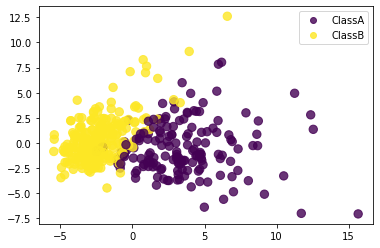

In [37]:
scatter = plt.scatter(Xtr_Pca[:,0], Xtr_Pca[:,1], s=70, c=ytrb, alpha=0.8)
classes = ['ClassA','ClassB']
plt.legend(handles=scatter.legend_elements()[0], labels=classes)

## Perform training and testing using the implimented Adaboost Algorithm and using the PCA version. 
Observe the difference in outputs. 

In [49]:
#Perform some training on the data set chosen using the two principal components
ada = AdaptiveBoost(18)
ada.xtrain(Xtr_Pca,ytrb)
Pred = ada.predict(Xte_Pca)

print ('The accuracy of the algorithm is '+ str(accuracy(yteb,Pred)))

The accuracy of the algorithm is 0.6900584795321637


In [58]:
def AdaboostVis(Xtr,ytr,Xte,yte,clfsmax):
    accur = []
    for i in range(1,clfsmax+1,1):
        ada = AdaptiveBoost(i)
        ada.xtrain(Xtr,ytr)
        Pred = ada.predict(Xte)
        acc = accuracy(yte,Pred)
        accur.append(acc)
    #print ('The accuracy of the algorithm is '+ str(accuracy(yte,Pred)))   
    plt.plot(accur)
    plt.xlabel('Number of Classifiers')
    plt.ylabel('Percentage of Accuracy')

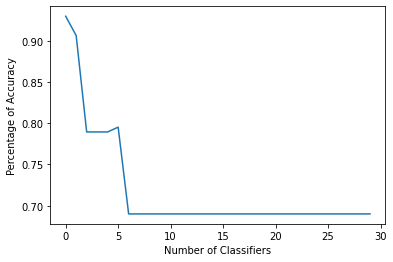

In [57]:
#Training with just the 2 principal components 
AdaboostVis(Xtr_Pca,ytrb,Xte_Pca,yteb,31)

In [44]:
#Perform some training on the data set chosen using all the components
ada = AdaptiveBoost(18)
ada.xtrain(Xtrb,ytrb)
Pred = ada.predict(Xteb)

print ('The accuracy of the algorithm is '+ str(accuracy(yteb,Pred)))

The accuracy of the algorithm is 0.7076023391812866


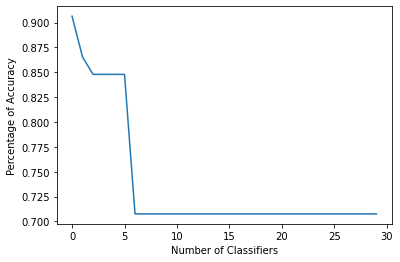

In [59]:
#This is the the training with all the components. It takes quite some time. 
AdaboostVis(Xtrb,ytrb,Xteb,yteb,30) 

In [64]:
def AdaboostVisSkl(Xtr,ytr,Xte,yte,clfsmax):
    accur = []
    for i in range(1,clfsmax+1,1):
        svc3=SVC(probability=True, kernel='linear')
        sklearnboost =AdaBoostClassifier(n_estimators=clfsmax, base_estimator=svc3,learning_rate=1)
        
        #Fit the model with data containing all components. 
        sklearnmodel3 = sklearnboost.fit(Xtr, ytr)
        
        #Predict the response for test dataset
        sklearnPredict3= sklearnmodel3.predict(Xte)
        
        acc = accuracy(yte,sklearnPredict3)
        accur.append(acc)  
        
    plt.plot(accur)
    plt.xlabel('Number of Classifiers')
    plt.ylabel('Percentage of Accuracy')

In [60]:
#Using skearn with 2 principal components 
# We will use a linear kernel for the support vector machine. 
svc3=SVC(probability=True, kernel='linear')
sklearnboost =AdaBoostClassifier(n_estimators=30, base_estimator=svc2,learning_rate=1)

#Fit the model with data containing only the 2 components. 
sklearnmodel2 = sklearnboost.fit(Xtr_Pca, ytrb)

#Predict the response for test dataset
sklearnPredict2= sklearnmodel2.predict(Xte_Pca)
print ('The accuracy of the algorithm is '+ str(accuracy(yteb,sklearnPredict2)))

The accuracy of the algorithm is 0.8245614035087719


In [62]:
#PCA 2 components
AdaboostVisSkl(Xtr_Pca,ytrb,Xte_Pca,yteb,40)

In [66]:
#Using skearn with all components with support vector classifier. 
svc3=SVC(probability=True, kernel='linear')
sklearnboost =AdaBoostClassifier(n_estimators=30, base_estimator=svc3,learning_rate=1)

#Fit the model with data containing all components. 
sklearnmodel3 = sklearnboost.fit(Xtrb, ytrb)

#Predict the response for test dataset
sklearnPredict3= sklearnmodel3.predict(Xteb)
print ('The accuracy of the algorithm is '+ str(accuracy(yteb,sklearnPredict3)))

The accuracy of the algorithm is 0.8654970760233918


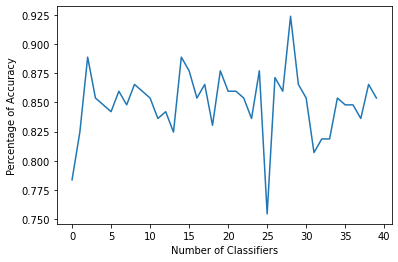

In [65]:
AdaboostVisSkl(Xtrb,ytrb,Xteb,yteb,40)

### Final points on the whole process and analysis. 
In this exercise i have implimented the Adaboost algorithm to train binary classification problems. Since adaboost needs a classfier that will predict atleast 50% of the labels right, i chose to use a decision stump that is a decision tree with just one level of depth. When i was training the algorithm i used 2 data sets first the synthetic one then on real breast cancer data. The performance of the algorithm on both data sets was not so off each other. Though what was noted is that the right number of classifiers determine the accuracy rate. For the example with the decision stump the accuracy rate drops significantly after the 7 classifiers and it stays constant. 